# Elo Score Calculation

In [1]:
import re
import os
import sys
from collections import defaultdict

In [2]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import xlrd
from labellines import labelLine, labelLines

In [4]:
# setting path
sys.path.append('../../src')

In [5]:
from eloscore import eloscore

In [6]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Importing Data for One Sheet

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [7]:
xls = pd.ExcelFile("./data/Urine_Marking_Assay_Data.xlsx")
sheets = xls.sheet_names

In [8]:
sheets

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

In [9]:
urine_marking_observations_df = pd.read_excel("./data/Urine_Marking_Assay_Data.xlsx", sheet_name=sheets[1], header=2)

In [10]:
copy_urine_marking_observations_df = urine_marking_observations_df.copy()

In [11]:
urine_marking_observations_df.head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,notes
0,2022-07-11,1vs2,17,13,1,2,NaN
1,2022-07-11,3vs4,14,7,3,4,NaN
2,2022-07-12,1vs3,22,38,3,1,NaN
3,2022-07-12,4vs2,8,12,2,4,NaN
4,2022-07-13,2vs3,3,110,3,2,NaN


## Adding the session number

- Each new session has the date as a row, so we will get the index of all the rows with dates

In [12]:
urine_marking_observations_df.dropna(axis=0, subset="date")

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,notes
0,2022-07-11,1vs2,17,13,1,2,NaN
1,2022-07-11,3vs4,14,7,3,4,NaN
2,2022-07-12,1vs3,22,38,3,1,NaN
3,2022-07-12,4vs2,8,12,2,4,NaN
4,2022-07-13,2vs3,3,110,3,2,NaN
5,2022-07-13,4vs1,6,6,tie,tie,NaN


- Dropping all rows that are ties

In [13]:
urine_marking_observations_df = urine_marking_observations_df[pd.to_numeric(urine_marking_observations_df['winner'], errors='coerce').notnull()]

- Getting the indexes of where each new session starts

In [14]:
urine_marking_observations_df.dropna(axis=0, subset="date").index

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [15]:
session_indexes = urine_marking_observations_df.dropna(axis=0, subset="date").index

- Adding a column for the session number and then filling all the `NaNs`

In [16]:
urine_marking_observations_df = eloscore.add_session_number_column(urine_marking_observations_df, session_indexes)
urine_marking_observations_df = urine_marking_observations_df.fillna(method='ffill')

- Making another column for plotting

In [17]:
urine_marking_observations_df = eloscore.add_session_number_column(urine_marking_observations_df, session_indexes, session_number_column="session_number_plotting")

In [18]:
urine_marking_observations_df.head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,notes,session_number,session_number_plotting
0,2022-07-11,1vs2,17,13,1,2,NaN,1.0,1.0
1,2022-07-11,3vs4,14,7,3,4,NaN,2.0,2.0
2,2022-07-12,1vs3,22,38,3,1,NaN,3.0,3.0
3,2022-07-12,4vs2,8,12,2,4,NaN,4.0,4.0
4,2022-07-13,2vs3,3,110,3,2,NaN,5.0,5.0


## Calculating ELO Score

- Example calculation

In [19]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1020

## Get the Elo score for all the events

In [20]:
urine_marking_observations_df.head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,notes,session_number,session_number_plotting
0,2022-07-11,1vs2,17,13,1,2,NaN,1.0,1.0
1,2022-07-11,3vs4,14,7,3,4,NaN,2.0,2.0
2,2022-07-12,1vs3,22,38,3,1,NaN,3.0,3.0
3,2022-07-12,4vs2,8,12,2,4,NaN,4.0,4.0
4,2022-07-13,2vs3,3,110,3,2,NaN,5.0,5.0


In [21]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

- Function that creates a dictionary that has the original/updated elo score for each event

In [22]:
index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=urine_marking_observations_df, winner_column="winner", loser_column="loser", additional_columns=["date", "session_number", "session_number_plotting"])

In [23]:
index_to_elo_score_and_meta_data[0]

{'total_match_number': 1,
 'subject_id': 1,
 'agent_id': 2,
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 'date': Timestamp('2022-07-11 00:00:00'),
 'session_number': 1.0,
 'session_number_plotting': 1.0}

- Turning the dictionary into a dataframe

In [24]:
urine_marking_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [25]:
urine_marking_elo_score_df.head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
0,1,1,2,1000.0,1010.0,1,2022-07-11,1.0,1.0
1,1,2,2,1000.0,990.0,1,2022-07-11,1.0,1.0
2,2,3,4,1000.0,1010.0,1,2022-07-11,2.0,2.0
3,2,4,4,1000.0,990.0,1,2022-07-11,2.0,2.0
4,3,3,1,1010.0,1020.0,1,2022-07-12,3.0,3.0


In [26]:
urine_marking_elo_score_df.tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
5,3,1,1,1010.0,1000.0,1,2022-07-12,3.0,3.0
6,4,2,4,990.0,1000.0,1,2022-07-12,4.0,4.0
7,4,4,4,990.0,980.0,1,2022-07-12,4.0,4.0
8,5,3,2,1020.0,1029.4,1,2022-07-13,5.0,5.0
9,5,2,2,1000.0,990.6,1,2022-07-13,5.0,5.0


In [27]:
urine_marking_elo_score_df.groupby("subject_id").count()

,total_match_number,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
subject_id,,,,,,,,
1,2,2,2,2,2,2,2,2
2,3,3,3,3,3,3,3,3
3,3,3,3,3,3,3,3,3
4,2,2,2,2,2,2,2,2


In [28]:
urine_marking_elo_score_df.groupby("session_number").count()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number_plotting
session_number,,,,,,,,
1.0,2,2,2,2,2,2,2,2
2.0,2,2,2,2,2,2,2,2
3.0,2,2,2,2,2,2,2,2
4.0,2,2,2,2,2,2,2,2
5.0,2,2,2,2,2,2,2,2


# Plotting the Elo Score by match number

In [29]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

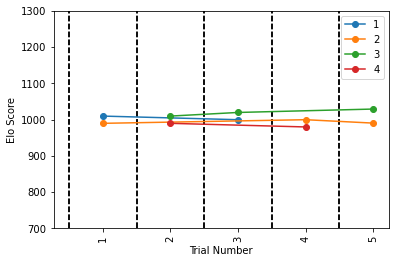

In [30]:
fig, ax = plt.subplots()

# Drawing vertical lines that represent when each session begins
for index, row in urine_marking_elo_score_df.dropna(subset=["session_number_plotting"]).iterrows():
    # Offsetting by 0.5 to avoid drawing the line on the dot
    plt.vlines(x=[row["total_match_number"] - 0.5], ymin=700, ymax=1300, colors='black', linestyle='dashed')

# Drawing a line for each subject
for subject in sorted(urine_marking_elo_score_df["subject_id"].unique()):
    # Getting all the rows with the current subject
    subject_df = urine_marking_elo_score_df[urine_marking_elo_score_df["subject_id"] == subject]
    # Making the dates into days after the first session by subtracting all the dates by the first date
    plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

# Labeling the X/Y Axis and the title
ax.set_xlabel("Trial Number")
ax.set_ylabel("Elo Score")
# ax.set_title("Elo Score for Home Cage Observation: Cage {}".format(cage))
# To show the legend
ax.legend()
plt.xticks(rotation=90)
plt.ylim(700, 1300) 
plt.show()



# Calculate the Elo Score for all sheets

In [31]:
xls = pd.ExcelFile("./data/Urine_Marking_Assay_Data.xlsx")
sheets = xls.sheet_names

In [32]:
sheets

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

In [33]:
sheet_to_data_frame = defaultdict(dict)
for sheet in sheets[:]:
    sheet_to_data_frame[sheet]["recording_data_frame"] = pd.read_excel("./data/Urine_Marking_Assay_Data.xlsx", sheet_name=sheet, header=2).copy()
    
    sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"][pd.to_numeric(sheet_to_data_frame[sheet]["recording_data_frame"]['winner'], errors='coerce').notnull()]
    
    # Adding the session numbers as a column
    session_indexes = sheet_to_data_frame[sheet]["recording_data_frame"].dropna(axis=0, subset="date").index
    sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes)
    sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].fillna(method='ffill')
    sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes, session_number_column="session_number_plotting")

    # Splitting all the rows with commas in the ID
    sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].astype(str)
    sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].astype(str)
    
    sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].str.split(",")
    sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].explode("winner").reset_index(drop=True)
    sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].str.split(",")
    sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].explode("loser").reset_index(drop=True)

    sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].astype(float).astype(int).astype(str)
    sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].astype(float).astype(int).astype(str)
    
    # Calculating the Elo Score    
    index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=sheet_to_data_frame[sheet]["recording_data_frame"], \
                                                                                                               winner_column="winner", loser_column="loser", additional_columns=["date", "session_number", "session_number_plotting"])
    sheet_to_data_frame[sheet]["elo_score_data_frame"] = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

# Making plots for all sheets

- Getting the dates the files were being recorded to use for the file name

In [34]:
sheets[0]

'CAGE1'

In [35]:
earliest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].min()).split()[0]

In [36]:
latest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].max()).split()[0]

In [37]:
earliest_date

'2022-07-11'

In [38]:
latest_date

'2022-07-13'

- Getting the cage numbers

In [39]:
all_cages = "_".join(sorted([sheet.lower().strip("cage").strip() for sheet in sheets[:]]))

In [40]:
all_cages

'1_2_3_4_5_6'

In [41]:
output_directory = "./proc/plots/urine_marking_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [42]:
output_directory

'./proc/plots/urine_marking_elo_score/cage_1_2_3_4_5_6_date_2022-07-11_2022-07-13'

In [43]:
os.makedirs(output_directory, exist_ok=True)

CAGE1


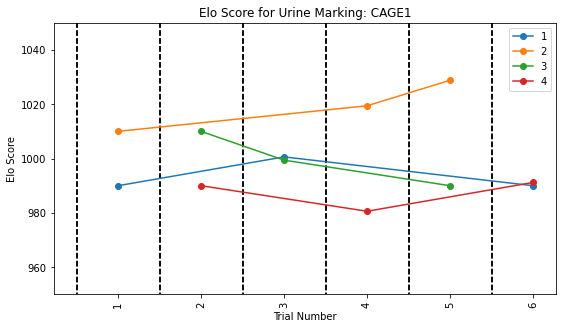

CAGE2


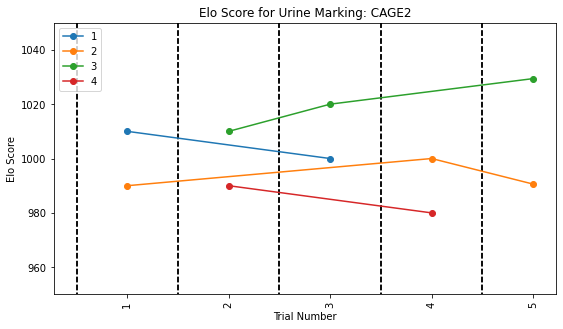

CAGE3


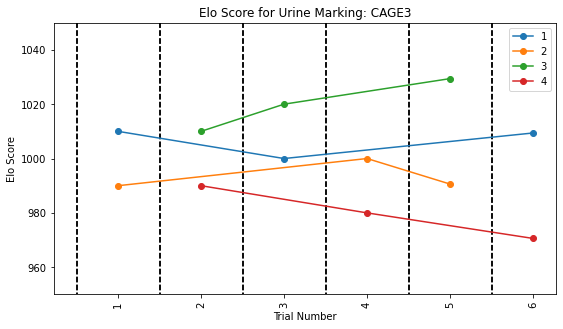

CAGE4


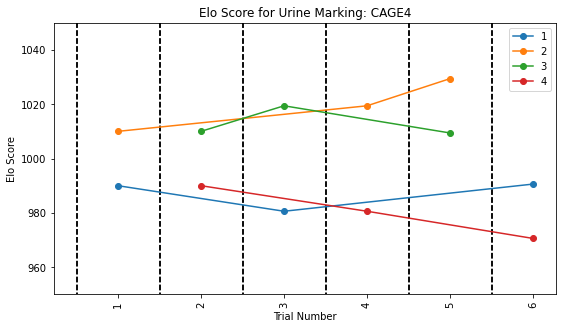

CAGE5


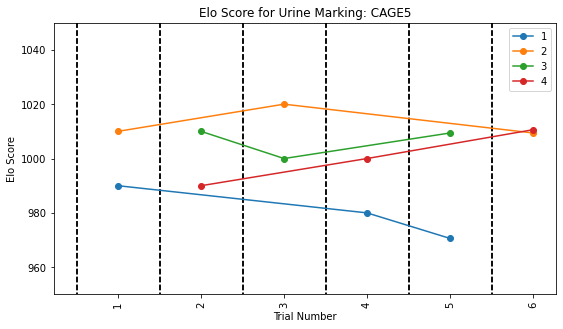

CAGE6


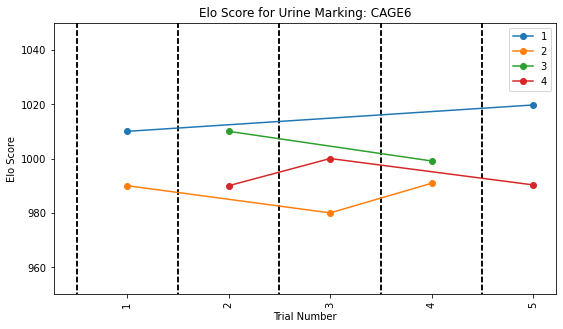

In [46]:
for key, value in sheet_to_data_frame.items():
    print(key)
    plt.rcParams["figure.figsize"] = (9,5)
    elo_score_data_frame = value["elo_score_data_frame"]
    fig, ax = plt.subplots()

    # Drawing vertical lines that represent when each session begins
    for index, row in elo_score_data_frame.dropna(subset=["session_number_plotting"]).iterrows():
        # Offsetting by 0.5 to avoid drawing the line on the dot
        plt.vlines(x=[row["total_match_number"] - 0.5], ymin=600, ymax=1400, colors='black', linestyle='dashed')

    # Drawing a line for each subject
    for subject in sorted(elo_score_data_frame["subject_id"].astype(str).unique()):
        # Getting all the rows with the current subject
        subject_df = elo_score_data_frame[elo_score_data_frame["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Urine Marking: {}".format(key))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(950, 1050) 
    
    file_name = "urine_marking_elo_score_{}_date_{}_{}.png".format(key, earliest_date, latest_date)
    plt.savefig(os.path.join(output_directory, file_name))
    
    plt.show()
